# Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids, get_population
from get_draws.api import get_draws

import altair as alt
from vega_datasets import data as map_data

In [2]:
ls /mnt/team/simulation_science/pub/models/vivarium_nih_us_cvd/results/final_runs/nih_us_cvd/2023_12_28_13_42_46/count_data

binned_ldl_exposure_time.csv  state_person_time.csv  ylls.csv
binned_sbp_exposure_time.csv  transition_count.csv
deaths.csv                    ylds.csv


In [3]:
sim_results_dir = '/mnt/team/simulation_science/pub/models/vivarium_nih_us_cvd/results/final_runs/nih_us_cvd/2023_12_28_13_42_46/count_data/'

In [4]:
pd.set_option('display.max_rows', None)

def convert(word):
    return ' '.join(x.capitalize() or '_' for x in word.split('_'))

In [5]:
US_pop = get_population(age_group_id= 157, #[22,1],
                              location_id=[523, 524, 525, 526, 527, 528, 529, 530,531, 532, 533,534, 535,
                                           536, 537, 538, 539, 540,541, 542, 543, 544 ,545, 546, 547, 548, 549, 550,
                                           551, 552, 553, 554, 555, 556, 557, 558, 559, 560,561, 562, 563, 564, 565, 
                                           566, 567, 568, 569, 570,571, 572, 573], 
                              year_id=2021, 
                              sex_id=[1,2],
                              release_id=9)
#US_pop = US_pop.groupby(['age_group_id','location_id']).population.mean().reset_index()
#under_5_value = US_pop[US_pop['age_group_id'] == 1].rename(columns = {'population':'under_5_pop'})
#US_pop = US_pop.merge(under_5_value[['under_5_pop','location_id']], on=['location_id'])
#US_pop['population'] -= US_pop['under_5_pop']
#US_pop = US_pop.loc[US_pop.age_group_id == 22].drop(columns=['under_5_pop'])
US_pop = US_pop.groupby(['location_id','year_id']).population.sum().reset_index()
US_pop.head()

,location_id,year_id,population
0,523,2021,3.450207e+06
1,524,2021,4.877846e+05
2,525,2021,4.928893e+06
3,526,2021,2.028129e+06
4,527,2021,2.735053e+07


In [6]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 
person_time = person_time.loc[(person_time['year'] == 2021) & (person_time.scenario == 'baseline')]
person_time = person_time.groupby(['input_draw','location']).value.sum().reset_index()
person_time = person_time.groupby(['location']).value.mean().reset_index()
person_time['location_name'] = person_time.location.apply(convert)
person_time = person_time.drop(columns=['location'])
person_time.head()

,value,location_name
0,78152.135797,Alabama
1,76384.873922,Alaska
2,77063.313347,Arizona
3,77054.014511,Arkansas
4,77973.319097,California


In [7]:
location_map = pd.read_csv('/ihme/homes/lutzes/vivarium_research_nih_us_cvd/CVD_locations.csv')
US_pop = US_pop.merge(location_map,on=['location_id'])
US_pop = US_pop.merge(person_time, on=['location_name'])
US_pop['scalar'] = US_pop['population'] / US_pop['value'] #/ 100_000
US_pop = US_pop.rename(columns = {'location_name':'location'})
US_pop.head()

,location_id,year_id,population,location,abbreviation,value,scalar
0,523,2021,3.450207e+06,Alabama,AL,78152.135797,44.147314
1,524,2021,4.877846e+05,Alaska,AK,76384.873922,6.385879
2,525,2021,4.928893e+06,Arizona,AZ,77063.313347,63.959001
3,526,2021,2.028129e+06,Arkansas,AR,77054.014511,26.320869
4,527,2021,2.735053e+07,California,CA,77973.319097,350.767843


In [8]:
## Okay, I feel good about the scalar values here. 
## Currently set up as age group 157 is 25+, we look at the pop in 2021 in baseline for each state (which is over 25) 

##  I also tested this as age group 22 (all ages) - age group 1 (under 5) and then dividing by 
## 100,000 (the per draw total pop) and got basically the same thing 

## Also for Alabama - the total state pop is about 5 million and we had 100,000 per seed/draw which 
## would give a scalar of 50. And we are a bit different since were note including the under 5 group

In [9]:
def subtract_baseline(group):
    baseline_value = group[group['scenario'] == 'baseline']['value'].values[0]
    group['averted_count'] = baseline_value - group['value']
    group['averted_percent'] = 100*((baseline_value - group['value'])/baseline_value)
    return group

def person_time_scalar(group):
    baseline_value = group[group['scenario'] == 'baseline']['value'].values[0]
    group['pt_scalar'] = baseline_value / group['value']
    return group
'''
def make_year_chunks(dataframe):
    dataframe['year_chunks'] = np.where(dataframe['year'].isin([2021,2022,2023,2024]), 2022.5, 
                                       np.where(dataframe['year'].isin([2025,2026,2027,2028]), 2026.5, 
                                               np.where(dataframe['year'].isin([2029,2030,2031,2032]), 2030.5,
                                                       np.where(dataframe['year'].isin([2033,2034,2035,2036]),2034.5, 2038.5))))
    return dataframe
'''

def make_year_chunks(dataframe):
    dataframe['year_chunks'] = np.where(dataframe['year'].isin([2021,2022]), 2021.5, 
                                       np.where(dataframe['year'].isin([2023,2024]), 2023.5, 
                                       np.where(dataframe['year'].isin([2025,2026]), 2025.5, 
                                       np.where(dataframe['year'].isin([2027,2028]), 2027.5, 
                                       np.where(dataframe['year'].isin([2029,2030]), 2029.5,
                                       np.where(dataframe['year'].isin([2031,2032]), 2031.5,
                                       np.where(dataframe['year'].isin([2033,2034]), 2033.5,
                                       np.where(dataframe['year'].isin([2035,2036]), 2035.5, 
                                       np.where(dataframe['year'].isin([2037,2038]), 2037.5, 2039.5)))))))))
    return dataframe 

def make_new_trans(dataframe):
    dataframe['transition_new'] = np.where(dataframe.transition.isin(['susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction','heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','post_myocardial_infarction_to_acute_myocardial_infarction']), 'Myocardial Infarction',
                                    np.where(dataframe.transition.isin(['susceptible_to_ischemic_stroke_to_acute_ischemic_stroke','chronic_ischemic_stroke_to_acute_ischemic_stroke']),'Ischemic Stroke',
                                    np.where(dataframe.transition.isin(['post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']),'Heart Failure','Other')))
    return dataframe

def make_age_buckets(dataframe):
    dataframe['age_bucket'] = np.where(np.isin(dataframe['age'],['25_to_29','30_to_34']),'under_35',
                                        np.where(np.isin(dataframe['age'],['35_to_39','40_to_44']),'35_to_45',
                                       np.where(np.isin(dataframe['age'],['45_to_49','50_to_54']),'45_to_55',
                                       np.where(np.isin(dataframe['age'],['55_to_59','60_to_64']),'55_to_65',
                                       np.where(np.isin(dataframe['age'],['65_to_69','70_to_74']),'65_to_75',
                                                np.where(np.isin(dataframe['age'],['75_to_79','80_to_84']),'75_to_85','over_85'))))))
    return dataframe

def make_new_causes(dataframe):
    dataframe['cause_new'] = np.where(np.isin(dataframe['cause'],['acute_ischemic_stroke','chronic_ischemic_stroke']),'Ischemic Stroke',
                                       np.where(np.isin(dataframe['cause'],['acute_myocardial_infarction','acute_myocardial_infarction_and_heart_failure','heart_failure_from_ischemic_heart_disease','post_myocardial_infarction']),'Ischemic Heart Disease','Other'))
    return dataframe

# Exploring Data

In [12]:
deaths = pd.read_csv(sim_results_dir + 'deaths.csv')
deaths.cause.unique()

array(['acute_ischemic_stroke', 'acute_myocardial_infarction',
       'acute_myocardial_infarction_and_heart_failure',
       'chronic_ischemic_stroke',
       'heart_failure_from_ischemic_heart_disease',
       'heart_failure_residual', 'other_causes',
       'post_myocardial_infarction'], dtype=object)

In [13]:
tran = pd.read_csv(sim_results_dir + 'transition_count.csv')
tran.transition.unique()

array(['acute_ischemic_stroke_to_chronic_ischemic_stroke',
       'acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease',
       'acute_myocardial_infarction_to_post_myocardial_infarction',
       'chronic_ischemic_stroke_to_acute_ischemic_stroke',
       'heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure',
       'post_myocardial_infarction_to_acute_myocardial_infarction',
       'post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease',
       'susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction',
       'susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease',
       'susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual',
       'susceptible_to_ischemic_stroke_to_acute_ischemic_stroke'],
      dtype=object)

# General PDF Function

Notes: this works for DALYs, YLLs, YLDs, deaths and incidence. Some things in the function need to be changed manually. These include: counts vs percent decrease (it is set to counts currently), and types of deaths/incidence. It was too complex to have the function auto-select the transitions or causes based on an input. The above section should be helpful in this. 

In [14]:
def pdf_generator(metric, groupby_columns, directory, pdf_title, measure_name):

    if metric == 'dalys':
        yll = pd.read_csv(sim_results_dir + 'ylls.csv')
        yll = yll.rename(columns = {'value':'yll'})
        yll = make_year_chunks(yll)
        yll = yll.groupby(groupby_columns).yll.sum().reset_index()
        yld = pd.read_csv(sim_results_dir + 'ylds.csv')
        yld = yld.rename(columns = {'value':'yld'})
        yld = make_year_chunks(yld)
        yld = yld.groupby(groupby_columns).yld.sum().reset_index()
        data = yll.merge(yld, on=groupby_columns)
        data['value'] = data['yll'] + data['yld']

    elif metric == 'deaths': 
        data = pd.read_csv(directory + 'deaths.csv')
        data = data.loc[data.cause.isin(['heart_failure_from_ischemic_heart_disease','heart_failure_residual','acute_ischemic_stroke','chronic_ischemic_stroke','acute_myocardial_infarction','acute_myocardial_infarction_and_heart_failure','post_myocardial_infarction'])]
        data = make_year_chunks(data)
#
    
    elif metric == 'incidence':
        data = pd.read_csv(directory + 'transition_count.csv')
        data = data.loc[data.transition.isin(['post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual'])]
        data = make_year_chunks(data)
#'post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual'
#'chronic_ischemic_stroke_to_acute_ischemic_stroke','susceptible_to_ischemic_stroke_to_acute_ischemic_stroke' 
#'heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','post_myocardial_infarction_to_acute_myocardial_infarction','susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction'
#'susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction','susceptible_to_ischemic_stroke_to_acute_ischemic_stroke','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual'
    else: 
        data = pd.read_csv(directory + f'{metric}.csv')
        data = make_year_chunks(data)
    
    data = data.groupby(groupby_columns).value.sum().reset_index()
    data['value'] = data['value'] / 2    
    data['location'] = data.location.apply(convert)
    data = data.merge(US_pop[['location','scalar']], on=['location'])
    data['value'] = data['value'] * data['scalar']
    
    state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
    person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 
    person_time['location'] = person_time.location.apply(convert)
    person_time = make_year_chunks(person_time)
    person_time = person_time.groupby(groupby_columns).value.sum().reset_index()
    pt_not_scenario = [x for x in groupby_columns if x != 'scenario']
    person_time = person_time.groupby(pt_not_scenario).apply(person_time_scalar)
    
    data = data.merge(person_time[groupby_columns+['pt_scalar']], on=groupby_columns)
    data['value'] = data['value'] * data['pt_scalar']
    
    groupby_not_scenario = [x for x in groupby_columns if x != 'scenario']
    data = data.groupby(groupby_not_scenario).apply(subtract_baseline)

    groupby_not_draw = [x for x in groupby_columns if x != 'input_draw']
    data_not_averted = data.groupby(groupby_not_draw).value.describe(percentiles=[.025, .975]).filter(['mean', '2.5%', '97.5%']).reset_index()
    data_count_final = data.groupby(groupby_not_draw).averted_count.describe(percentiles=[.025, .975]).filter(['mean', '2.5%', '97.5%']).reset_index()
    data_percent_final = data.groupby(groupby_not_draw).averted_percent.describe(percentiles=[.025, .975]).filter(['mean', '2.5%', '97.5%']).reset_index()

    with PdfPages(pdf_title) as pdf:
##Change this line to be what you want: data NOT averted is overall counts, and then count and percent averted 
        graph_data = data_not_averted
        for location in graph_data.location.unique():
            #for sex in graph_data.sex.unique():
            plt.figure()
            subdata = graph_data.loc[(graph_data.location==location) & (graph_data.scenario=='baseline')]
            plt.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = 'Baseline')
            #plt.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
            subdata = graph_data.loc[(graph_data.location==location) & (graph_data.scenario=='lifestyle_100')]
            plt.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label='Community-based NDPP')
            #plt.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
            subdata = graph_data.loc[(graph_data.location==location) & (graph_data.scenario=='outreach_100')]
            plt.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = 'Nurse intervention to increase medication adherence')
            #plt.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
            subdata = graph_data.loc[(graph_data.location==location) & (graph_data.scenario=='polypill_100')]
            plt.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = 'FDC antihypertensive')
            #plt.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
            plt.title(f'{measure_name} for {location}')
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.xticks(rotation=90) 
            plt.xlabel('Year')
            plt.xticks(ticks=[2022.5, 2025, 2027.5, 2030, 2032.5, 2035,2037.5, 2040], labels=['','2025','','2030','','2035','','2040'])
            plt.ylabel(f'{measure_name}')
            pdf.savefig(bbox_inches='tight')

# Doing some other final figures. First incidence for each cause for all US

In [10]:
def make_new_trans(dataframe):
    dataframe['transition_new'] = np.where(dataframe.transition.isin(['susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction','heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','post_myocardial_infarction_to_acute_myocardial_infarction']), 'Myocardial Infarction',
                                    np.where(dataframe.transition.isin(['susceptible_to_ischemic_stroke_to_acute_ischemic_stroke','chronic_ischemic_stroke_to_acute_ischemic_stroke']),'Ischemic Stroke',
                                    np.where(dataframe.transition.isin(['post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']),'Heart Failure','Other')))
    return dataframe

def make_year_chunks(dataframe):
    dataframe['year_chunks'] = np.where(dataframe['year'].isin([2021,2022]), 2021.5, 
                                       np.where(dataframe['year'].isin([2023,2024]), 2023.5, 
                                       np.where(dataframe['year'].isin([2025,2026]), 2025.5, 
                                       np.where(dataframe['year'].isin([2027,2028]), 2027.5, 
                                       np.where(dataframe['year'].isin([2029,2030]), 2029.5,
                                       np.where(dataframe['year'].isin([2031,2032]), 2031.5,
                                       np.where(dataframe['year'].isin([2033,2034]), 2033.5,
                                       np.where(dataframe['year'].isin([2035,2036]), 2035.5, 
                                       np.where(dataframe['year'].isin([2037,2038]), 2037.5, 2039.5)))))))))
    return dataframe 

groupby_columns = ['input_draw','year','scenario']

In [38]:
data = pd.read_csv(sim_results_dir + 'transition_count.csv')
data = data.loc[(data.year == 2021) & (data.scenario == 'baseline') & (data.input_draw == 29) & (data.transition.isin(['post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))]
#data = data.loc[(data.year == 2021) & (data.scenario == 'baseline') & (data.input_draw == 29) & (data.transition.isin(['chronic_ischemic_stroke_to_acute_ischemic_stroke','susceptible_to_ischemic_stroke_to_acute_ischemic_stroke']))]
#data = data.loc[(data.year == 2021) & (data.scenario == 'baseline') & (data.input_draw == 29) & (data.transition.isin(['susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction','heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','post_myocardial_infarction_to_acute_myocardial_infarction']))]
data = data.groupby('location').value.sum().reset_index()
data.head()

,location,value
0,alabama,735.0
1,alaska,371.0
2,arizona,577.0
3,arkansas,794.0
4,california,685.0


In [19]:
data = pd.read_csv(sim_results_dir + 'transition_count.csv')
data = make_new_trans(data)
#data = make_year_chunks(data)
data = data.groupby(groupby_columns+['transition_new','location']).value.sum().reset_index()
data.head()

,input_draw,year,scenario,transition_new,location,value
0,29,2021,baseline,Heart Failure,alabama,735.0
1,29,2021,baseline,Heart Failure,alaska,371.0
2,29,2021,baseline,Heart Failure,arizona,577.0
3,29,2021,baseline,Heart Failure,arkansas,794.0
4,29,2021,baseline,Heart Failure,california,685.0


In [20]:
data['location'] = data.location.apply(convert)
data = data.merge(US_pop[['location','scalar']], on=['location'])
data['value'] = data['value'] * data['scalar']
#data = data.groupby(groupby_columns+['transition_new']).value.sum().reset_index()    
data.loc[(data.year == 2021) & (data.scenario == 'baseline') & (data.input_draw == 946) & (data.transition_new == 'Heart Failure')]#.value.sum()

2130410.5016790987

In [17]:
def pdf_generator(groupby_columns, directory, pdf_title):
    data = pd.read_csv(directory + 'transition_count.csv')
    data = make_new_trans(data)
    data = make_year_chunks(data)
    data = data.groupby(groupby_columns+['transition_new']).value.sum().reset_index()
    data['value'] = data['value'] / 2

    data['location'] = data.location.apply(convert)
    data = data.merge(US_pop[['location','scalar']], on=['location'])
    data['value'] = data['value'] * data['scalar']
    data = data.groupby(groupby_columns+['transition_new']).value.sum().reset_index()

    state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
    person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 
    person_time['location'] = person_time.location.apply(convert)
    person_time = make_year_chunks(person_time)
    person_time = person_time.groupby(groupby_columns).value.sum().reset_index()
    pt_not_scenario = [x for x in groupby_columns if x != 'scenario']
    person_time = person_time.groupby(pt_not_scenario).apply(person_time_scalar)
    
    data = data.merge(person_time[groupby_columns+['pt_scalar']], on=groupby_columns)
    data['value'] = data['value'] * data['pt_scalar']
    
    #groupby_not_scenario = [x for x in (groupby_columns+['transition_new']) if x != 'scenario']
    #data = data.groupby(groupby_not_scenario).apply(subtract_baseline)

    groupby_not_draw = [x for x in (groupby_columns+['transition_new']) if x != 'input_draw']
    data_not_averted = data.groupby(groupby_not_draw).value.describe(percentiles=[.025, .975]).filter(['mean', '2.5%', '97.5%']).reset_index()
    #data_count_final = data.groupby(groupby_not_draw).averted_count.describe(percentiles=[.025, .975]).filter(['mean', '2.5%', '97.5%']).reset_index()
    #data_percent_final = data.groupby(groupby_not_draw).averted_percent.describe(percentiles=[.025, .975]).filter(['mean', '2.5%', '97.5%']).reset_index()
    data_not_averted = data_not_averted.loc[data_not_averted.year_chunks != 2021.5]
    
    with PdfPages(pdf_title) as pdf:
        for state in data_not_averted.location.unique():
            data = data_not_averted.loc[data_not_averted.location == state]
            fig = plt.figure(figsize=(8,12))
            fig.subplots_adjust(hspace=0.3, wspace=0.4)
            plt.suptitle(f'Comparing Incidence Across Scenarios in {state}')
            ax = fig.add_subplot(3, 2, 1)
    
            subdata = data.loc[(data.transition_new=='Myocardial Infarction') & (data.scenario=='baseline') & (data.sex == 'Female')]
            ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = 'Baseline')
            #ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
            subdata = data.loc[(data.transition_new=='Myocardial Infarction') & (data.scenario=='lifestyle_100') & (data.sex == 'Female')]
            ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = 'Community-based NDPP')
            #ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
            subdata = data.loc[(data.transition_new=='Myocardial Infarction') & (data.scenario=='outreach_100') & (data.sex == 'Female')]
            ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = 'Nurse intervention to increase medication adherence')
            #ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
            subdata = data.loc[(data.transition_new=='Myocardial Infarction') & (data.scenario=='polypill_100') & (data.sex == 'Female')]
            ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o',label = 'FDC antihypertensive')
            #ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
            
            ax.set_title('Count of Myocardial Infarctions in Females')
            ax.set_xlabel('Year')
            ylabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_yticks()/1000]
            ax.set_yticklabels(ylabels)
            ax.set_xticks(ticks=[2022.5, 2025, 2027.5, 2030, 2032.5, 2035,2037.5, 2040], labels=['','2025','','2030','','2035','','2040'])
            ax.set_ylabel(f'Myocaridal Infarctions')
    
            ax = fig.add_subplot(3, 2, 2)
    
            subdata = data.loc[(data.transition_new=='Myocardial Infarction') & (data.scenario=='baseline') & (data.sex == 'Male')]
            ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = 'Baseline')
            #ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
            subdata = data.loc[(data.transition_new=='Myocardial Infarction') & (data.scenario=='lifestyle_100') & (data.sex == 'Male')]
            ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = 'Community-based NDPP')
            #ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
            subdata = data.loc[(data.transition_new=='Myocardial Infarction') & (data.scenario=='outreach_100') & (data.sex == 'Male')]
            ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = 'Nurse intervention to increase medication adherence')
            #ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
            subdata = data.loc[(data.transition_new=='Myocardial Infarction') & (data.scenario=='polypill_100') & (data.sex == 'Male')]
            ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o',label = 'FDC antihypertensive')
            #ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
            
            ax.set_title('Count of Myocardial Infarctions in Males')
            ax.set_xlabel('Year')
            ylabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_yticks()/1000]
            ax.set_yticklabels(ylabels)
            ax.set_xticks(ticks=[2022.5, 2025, 2027.5, 2030, 2032.5, 2035,2037.5, 2040], labels=['','2025','','2030','','2035','','2040'])
            ax.set_ylabel(f'Myocaridal Infarctions')
    
    
            ax = fig.add_subplot(3, 2, 3)
    
            subdata = data.loc[(data.transition_new=='Heart Failure') & (data.scenario=='baseline') & (data.sex == 'Female')]
            ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = 'Baseline')
            #ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
            subdata = data.loc[(data.transition_new=='Heart Failure') & (data.scenario=='lifestyle_100') & (data.sex == 'Female')]
            ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = 'Community-based NDPP')
            #ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
            subdata = data.loc[(data.transition_new=='Heart Failure') & (data.scenario=='outreach_100') & (data.sex == 'Female')]
            ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = 'Nurse intervention to increase medication adherence')
            #ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
            subdata = data.loc[(data.transition_new=='Heart Failure') & (data.scenario=='polypill_100') & (data.sex == 'Female')]
            ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o',label = 'FDC antihypertensive')
            #ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
            
            ax.set_title('Count of Heart Failure in Females')
            ax.set_xlabel('Year')
            ylabels = ['{:,.2f}'.format(x) + 'M' for x in ax.get_yticks()/1000000]
            ax.set_yticklabels(ylabels)
            ax.set_xticks(ticks=[2022.5, 2025, 2027.5, 2030, 2032.5, 2035,2037.5, 2040], labels=['','2025','','2030','','2035','','2040'])
            ax.set_ylabel(f'Heart Failure Cases')
    
            ax = fig.add_subplot(3, 2, 4)
    
            subdata = data.loc[(data.transition_new=='Heart Failure') & (data.scenario=='baseline') & (data.sex == 'Male')]
            ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = 'Baseline')
            #ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
            subdata = data.loc[(data.transition_new=='Heart Failure') & (data.scenario=='lifestyle_100') & (data.sex == 'Male')]
            ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = 'Community-based NDPP')
            #ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
            subdata = data.loc[(data.transition_new=='Heart Failure') & (data.scenario=='outreach_100') & (data.sex == 'Male')]
            ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = 'Nurse intervention to increase medication adherence')
            #ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
            subdata = data.loc[(data.transition_new=='Heart Failure') & (data.scenario=='polypill_100') & (data.sex == 'Male')]
            ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o',label = 'FDC antihypertensive')
            #ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
            
            ax.set_title('Count of Heart Failure in Males')
            ax.set_xlabel('Year')
            ylabels = ['{:,.2f}'.format(x) + 'M' for x in ax.get_yticks()/1000000]
            ax.set_yticklabels(ylabels)
            ax.set_xticks(ticks=[2022.5, 2025, 2027.5, 2030, 2032.5, 2035,2037.5, 2040], labels=['','2025','','2030','','2035','','2040'])
            ax.set_ylabel(f'Heart Failure Cases')
    
            
            ax = fig.add_subplot(3, 2, 5)
    
            subdata = data.loc[(data.transition_new=='Ischemic Stroke') & (data.scenario=='baseline') & (data.sex == 'Female')]
            ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = 'Baseline')
            #ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
            subdata = data.loc[(data.transition_new=='Ischemic Stroke') & (data.scenario=='lifestyle_100') & (data.sex == 'Female')]
            ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = 'Community-based NDPP')
            #ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
            subdata = data.loc[(data.transition_new=='Ischemic Stroke') & (data.scenario=='outreach_100') & (data.sex == 'Female')]
            ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = 'Nurse intervention to increase medication adherence')
            #ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
            subdata = data.loc[(data.transition_new=='Ischemic Stroke') & (data.scenario=='polypill_100') & (data.sex == 'Female')]
            ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o',label = 'FDC antihypertensive')
            #ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
            
            ax.set_title('Count of Ischemic Strokes in Females')
            ax.set_xlabel('Year')
            ylabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_yticks()/1000]
            ax.set_yticklabels(ylabels)
            ax.set_xticks(ticks=[2022.5, 2025, 2027.5, 2030, 2032.5, 2035,2037.5, 2040], labels=['','2025','','2030','','2035','','2040'])
            ax.set_ylabel(f'Ischemic Strokes')
    
            ax = fig.add_subplot(3, 2, 6)
    
            subdata = data.loc[(data.transition_new=='Ischemic Stroke') & (data.scenario=='baseline') & (data.sex == 'Male')]
            ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = 'Baseline')
            #ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
            subdata = data.loc[(data.transition_new=='Ischemic Stroke') & (data.scenario=='lifestyle_100') & (data.sex == 'Male')]
            ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = 'Community-based NDPP')
            #ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
            subdata = data.loc[(data.transition_new=='Ischemic Stroke') & (data.scenario=='outreach_100') & (data.sex == 'Male')]
            ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = 'Nurse intervention to increase medication adherence')
            #ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
            subdata = data.loc[(data.transition_new=='Ischemic Stroke') & (data.scenario=='polypill_100') & (data.sex == 'Male')]
            ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o',label = 'FDC antihypertensive')
            #ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
            
            ax.set_title('Count of Ischemic Strokes in Males')
            ax.set_xlabel('Year')
            ax.set_xticks(ticks=[2022.5, 2025, 2027.5, 2030, 2032.5, 2035,2037.5, 2040], labels=['','2025','','2030','','2035','','2040'])
            ylabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_yticks()/1000]
            ax.set_yticklabels(ylabels)
            ax.set_ylabel(f'Ischemic Strokes')
            plt.legend(loc='upper center', bbox_to_anchor=(-0.3, -0.15))
    
            pdf.savefig(bbox_inches='tight')

In [19]:
groupby_columns = ['input_draw','year_chunks','scenario','sex','location']

#pdf_generator(groupby_columns, sim_results_dir, 'incidence_states_2_1_2024.pdf')

# Next, by age bucket

In [19]:
def pdf_generator(metric, groupby_columns, directory, pdf_title):
    if metric == 'dalys':
        yll = pd.read_csv(sim_results_dir + 'ylls.csv')
        yll = yll.rename(columns = {'value':'yll'})
        yll = make_year_chunks(yll)
        yll = make_age_buckets(yll)
        yll = yll.groupby(groupby_columns+['location']).yll.sum().reset_index()
        yld = pd.read_csv(sim_results_dir + 'ylds.csv')
        yld = yld.rename(columns = {'value':'yld'})
        yld = make_year_chunks(yld)
        yld = make_age_buckets(yld)
        yld = yld.groupby(groupby_columns+['location']).yld.sum().reset_index()
        data = yll.merge(yld, on=groupby_columns+['location'])
        data['value'] = data['yll'] + data['yld']

    elif metric == 'deaths': 
        data = pd.read_csv(directory + 'deaths.csv')
        data = data.loc[data.cause.isin(['heart_failure_from_ischemic_heart_disease','heart_failure_residual','acute_ischemic_stroke','chronic_ischemic_stroke','acute_myocardial_infarction','acute_myocardial_infarction_and_heart_failure','post_myocardial_infarction'])]
        data = make_year_chunks(data)
        data = make_age_buckets(data)
#
    
    elif metric == 'incidence':
        data = pd.read_csv(directory + 'transition_count.csv')
        data = data.loc[data.transition.isin(['post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual'])]
        data = make_year_chunks(data)
        data = make_age_buckets(data)
#'post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual'
#'chronic_ischemic_stroke_to_acute_ischemic_stroke','susceptible_to_ischemic_stroke_to_acute_ischemic_stroke' 
#'heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','post_myocardial_infarction_to_acute_myocardial_infarction','susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction'
#'susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction','susceptible_to_ischemic_stroke_to_acute_ischemic_stroke','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual'
    
    data['location'] = data.location.apply(convert)
    data = data.merge(US_pop[['location','scalar']], on=['location'])
    data['value'] = data['value'] * data['scalar']
    data = data.groupby(groupby_columns).value.sum().reset_index()    
    data['value'] = data['value'] / 2

    state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
    person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 
    person_time = make_year_chunks(person_time)
    person_time = make_age_buckets(person_time)
    person_time = person_time.groupby(groupby_columns).value.sum().reset_index()
    pt_not_scenario = [x for x in groupby_columns if x != 'scenario']
    person_time = person_time.groupby(pt_not_scenario).apply(person_time_scalar)
    
    data = data.merge(person_time[groupby_columns+['pt_scalar']], on=groupby_columns)
    data['value'] = data['value'] * data['pt_scalar']
    
    groupby_not_scenario = [x for x in groupby_columns if x != 'scenario']
    data = data.groupby(groupby_not_scenario).apply(subtract_baseline)

    groupby_not_draw = [x for x in groupby_columns if x != 'input_draw']
    data_not_averted = data.groupby(groupby_not_draw).value.describe(percentiles=[.025, .975]).filter(['mean', '2.5%', '97.5%']).reset_index()
    data_count_final = data.groupby(groupby_not_draw).averted_count.describe(percentiles=[.025, .975]).filter(['mean', '2.5%', '97.5%']).reset_index()
    data_percent_final = data.groupby(groupby_not_draw).averted_percent.describe(percentiles=[.025, .975]).filter(['mean', '2.5%', '97.5%']).reset_index()

    with PdfPages(pdf_title) as pdf:
        data = data_count_final
        fig = plt.figure(figsize=(8,13))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        plt.suptitle(f'Comparing CVD DALYs Averted by Age Group and Sex between Scenarios')
        ax = fig.add_subplot(3, 2, 1)

        subdata = data.loc[(data.scenario=='polypill_100') & (data.age_bucket=='under_35') & (data.sex == 'Female')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = 'Under 35')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='polypill_100') & (data.age_bucket=='35_to_45') & (data.sex == 'Female')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '35 to 45')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='polypill_100') & (data.age_bucket=='45_to_55') & (data.sex == 'Female')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '45 to 55')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='polypill_100') & (data.age_bucket=='55_to_65') & (data.sex == 'Female')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '55 to 65')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='polypill_100') & (data.age_bucket=='65_to_75') & (data.sex == 'Female')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '65 to 75')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='polypill_100') & (data.age_bucket=='75_to_85') & (data.sex == 'Female')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '75 to 85')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='polypill_100') & (data.age_bucket=='over_85') & (data.sex == 'Female')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o',label = 'Over 85')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        
        ax.set_title('FDC Antihypertensive Scenario in Females')
        ax.set_xlabel('Year')
        ylabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_yticks()/1000]
        ax.set_yticklabels(ylabels)
        ax.set_xticks(ticks=[2022.5, 2025, 2027.5, 2030, 2032.5, 2035,2037.5, 2040], labels=['','2025','','2030','','2035','','2040'])
        ax.set_ylabel(f'Averted DALYs')
        
        ax = fig.add_subplot(3, 2, 2)

        subdata = data.loc[(data.scenario=='polypill_100') & (data.age_bucket=='under_35') & (data.sex == 'Male')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = 'Under 35')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='polypill_100') & (data.age_bucket=='35_to_45') & (data.sex == 'Male')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '35 to 45')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='polypill_100') & (data.age_bucket=='45_to_55') & (data.sex == 'Male')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '45 to 55')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='polypill_100') & (data.age_bucket=='55_to_65') & (data.sex == 'Male')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '55 to 65')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='polypill_100') & (data.age_bucket=='65_to_75') & (data.sex == 'Male')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '65 to 75')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='polypill_100') & (data.age_bucket=='75_to_85') & (data.sex == 'Male')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '75 to 85')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='polypill_100') & (data.age_bucket=='over_85') & (data.sex == 'Male')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o',label = 'Over 85')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        
        ax.set_title('FDC Antihypertensive Scenario in Males')
        ax.set_xlabel('Year')
        ylabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_yticks()/1000]
        ax.set_yticklabels(ylabels)
        ax.set_xticks(ticks=[2022.5, 2025, 2027.5, 2030, 2032.5, 2035,2037.5, 2040], labels=['','2025','','2030','','2035','','2040'])
        ax.set_ylabel(f'Averted DALYs')
        

        ax = fig.add_subplot(3, 2, 3)

        subdata = data.loc[(data.scenario=='outreach_100') & (data.age_bucket=='under_35') & (data.sex == 'Female')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = 'Under 35')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='outreach_100') & (data.age_bucket=='35_to_45') & (data.sex == 'Female')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '35 to 45')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='outreach_100') & (data.age_bucket=='45_to_55') & (data.sex == 'Female')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '45 to 55')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='outreach_100') & (data.age_bucket=='55_to_65') & (data.sex == 'Female')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '55 to 65')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='outreach_100') & (data.age_bucket=='65_to_75') & (data.sex == 'Female')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '65 to 75')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='outreach_100') & (data.age_bucket=='75_to_85') & (data.sex == 'Female')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '75 to 85')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='outreach_100') & (data.age_bucket=='over_85') & (data.sex == 'Female')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o',label = 'Over 85')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        
        ax.set_title('Nurse Intervention to Increase\nMedication Adherence in Females')
        ylabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_yticks()/1000]
        ax.set_yticklabels(ylabels)
        ax.set_xlabel('Year')
        ax.set_xticks(ticks=[2022.5, 2025, 2027.5, 2030, 2032.5, 2035,2037.5, 2040], labels=['','2025','','2030','','2035','','2040'])
        ax.set_ylabel(f'Averted DALYs')

        ax = fig.add_subplot(3, 2, 4)

        subdata = data.loc[(data.scenario=='outreach_100') & (data.age_bucket=='under_35') & (data.sex == 'Male')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = 'Under 35')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='outreach_100') & (data.age_bucket=='35_to_45') & (data.sex == 'Male')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '35 to 45')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='outreach_100') & (data.age_bucket=='45_to_55') & (data.sex == 'Male')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '45 to 55')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='outreach_100') & (data.age_bucket=='55_to_65') & (data.sex == 'Male')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '55 to 65')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='outreach_100') & (data.age_bucket=='65_to_75') & (data.sex == 'Male')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '65 to 75')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='outreach_100') & (data.age_bucket=='75_to_85') & (data.sex == 'Male')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '75 to 85')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='outreach_100') & (data.age_bucket=='over_85') & (data.sex == 'Male')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o',label = 'Over 85')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        
        ax.set_title('Nurse Intervention to Increase\nMedication Adherence in Males')
        ylabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_yticks()/1000]
        ax.set_yticklabels(ylabels)
        ax.set_xlabel('Year')
        ax.set_xticks(ticks=[2022.5, 2025, 2027.5, 2030, 2032.5, 2035,2037.5, 2040], labels=['','2025','','2030','','2035','','2040'])
        ax.set_ylabel(f'Averted DALYs')


        ax = fig.add_subplot(3, 2, 5)

        subdata = data.loc[(data.scenario=='lifestyle_100') & (data.age_bucket=='under_35') & (data.sex == 'Female')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = 'Under 35')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='lifestyle_100') & (data.age_bucket=='35_to_45') & (data.sex == 'Female')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '35 to 45')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='lifestyle_100') & (data.age_bucket=='45_to_55') & (data.sex == 'Female')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '45 to 55')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='lifestyle_100') & (data.age_bucket=='55_to_65') & (data.sex == 'Female')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '55 to 65')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='lifestyle_100') & (data.age_bucket=='65_to_75') & (data.sex == 'Female')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '65 to 75')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='lifestyle_100') & (data.age_bucket=='75_to_85') & (data.sex == 'Female')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '75 to 85')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='lifestyle_100') & (data.age_bucket=='over_85') & (data.sex == 'Female')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o',label = 'Over 85')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        
        ax.set_title('Community-Based NDPP Scenario in Females')
        ax.set_xlabel('Year')
        ylabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_yticks()/1000]
        ax.set_yticklabels(ylabels)
        ax.set_xticks(ticks=[2022.5, 2025, 2027.5, 2030, 2032.5, 2035,2037.5, 2040], labels=['','2025','','2030','','2035','','2040'])
        ax.set_ylabel(f'Averted DALYs')

        ax = fig.add_subplot(3, 2, 6)

        subdata = data.loc[(data.scenario=='lifestyle_100') & (data.age_bucket=='under_35') & (data.sex == 'Male')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = 'Under 35')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='lifestyle_100') & (data.age_bucket=='35_to_45') & (data.sex == 'Male')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '35 to 45')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='lifestyle_100') & (data.age_bucket=='45_to_55') & (data.sex == 'Male')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '45 to 55')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='lifestyle_100') & (data.age_bucket=='55_to_65') & (data.sex == 'Male')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '55 to 65')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='lifestyle_100') & (data.age_bucket=='65_to_75') & (data.sex == 'Male')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '65 to 75')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='lifestyle_100') & (data.age_bucket=='75_to_85') & (data.sex == 'Male')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o', label = '75 to 85')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        subdata = data.loc[(data.scenario=='lifestyle_100') & (data.age_bucket=='over_85') & (data.sex == 'Male')]
        ax.plot(subdata['year_chunks'], subdata['mean'], marker = 'o',label = 'Over 85')
        ax.fill_between(subdata['year_chunks'], subdata['2.5%'], subdata['97.5%'], alpha = 0.3)
        
        ax.set_title('Community-Based NDPP in Males')
        ax.set_xlabel('Year')
        ylabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_yticks()/1000]
        ax.set_yticklabels(ylabels)
        ax.set_xticks(ticks=[2022.5, 2025, 2027.5, 2030, 2032.5, 2035,2037.5, 2040], labels=['','2025','','2030','','2035','','2040'])
        plt.legend(loc='upper center', bbox_to_anchor=(-0.3, -0.15), ncol=3)
        ax.set_ylabel(f'Averted DALYs')

        pdf.savefig(bbox_inches='tight')

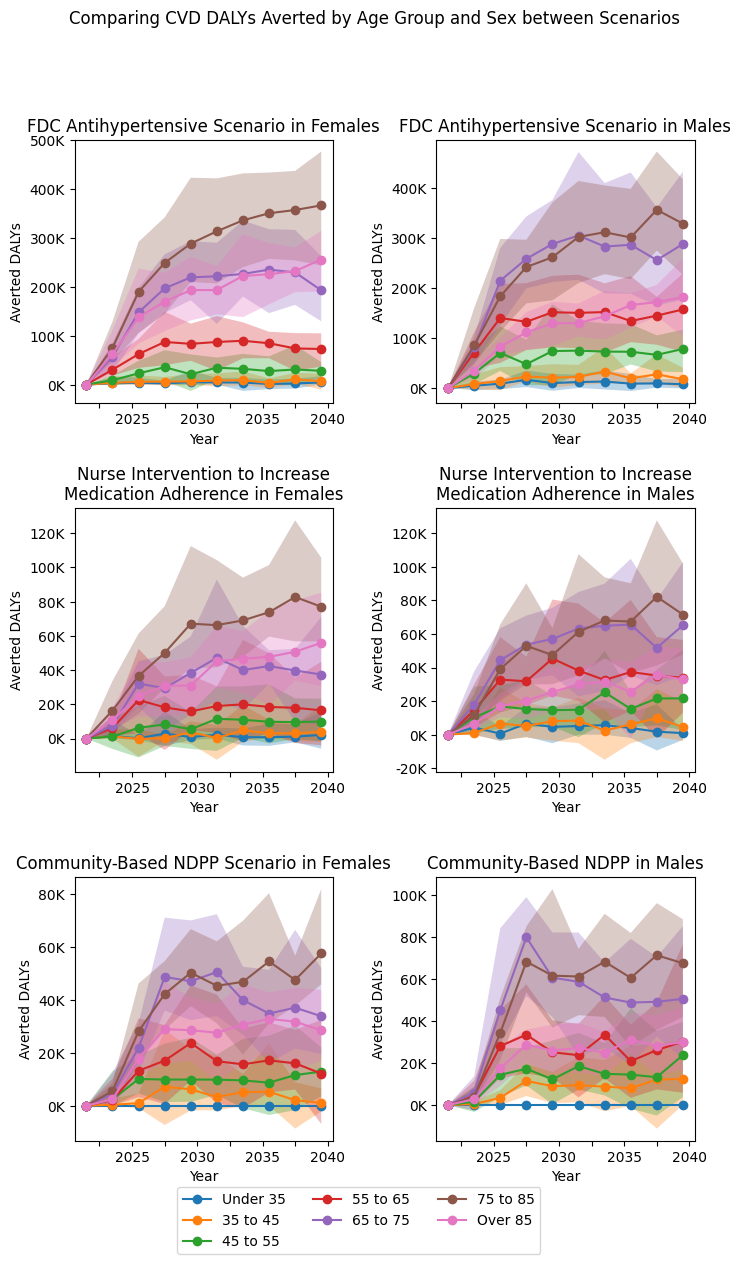

In [20]:
groupby_columns = ['input_draw','year_chunks','age_bucket','scenario','sex']
metric = 'dalys'

pdf_generator(metric, groupby_columns, sim_results_dir, 'dalys_by_age_bucket_us_1_24_2024.pdf')

# Final Map Figure(s)

In [82]:
def map_generator(groupby_columns, directory):
    yll = pd.read_csv(sim_results_dir + 'ylls.csv')
    yll = yll.rename(columns = {'value':'yll'})
    #yll = make_new_causes(yll)
    yll = yll.groupby(groupby_columns).yll.sum().reset_index()
    yld = pd.read_csv(sim_results_dir + 'ylds.csv')
    yld = yld.rename(columns = {'value':'yld','cause_of_disability':'cause'})
    #yld = make_new_causes(yld)
    yld = yld.groupby(groupby_columns).yld.sum().reset_index()
    data = yll.merge(yld, on=(groupby_columns))
    data['value'] = data['yll'] + data['yld']
        
    state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
    person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 
    person_time = person_time.groupby(groupby_columns).value.sum().reset_index()
    pt_not_scenario = [x for x in groupby_columns if x != 'scenario']
    person_time = person_time.groupby(pt_not_scenario).apply(person_time_scalar)
    
    data = data.merge(person_time[groupby_columns+['pt_scalar']], on=groupby_columns)
    data['value'] = data['value'] * data['pt_scalar']
    
    groupby_not_scenario = [x for x in (groupby_columns) if x != 'scenario']
    data = data.groupby(groupby_not_scenario).apply(subtract_baseline)

    groupby_not_draw = [x for x in (groupby_columns) if x != 'input_draw']
    data_not_averted = data.groupby(groupby_not_draw).value.describe(percentiles=[.025, .975]).filter(['mean', '2.5%', '97.5%']).reset_index()
    data_count_final = data.groupby(groupby_not_draw).averted_count.describe(percentiles=[.025, .975]).filter(['mean', '2.5%', '97.5%']).reset_index()
    data_percent_final = data.groupby(groupby_not_draw).averted_percent.describe(percentiles=[.025, .975]).filter(['mean', '2.5%', '97.5%']).reset_index()
    
    graph_data_big = data_percent_final
    charts = []

    for intervention in ['polypill_100','outreach_100','lifestyle_100']: 
        graph_data = graph_data_big.loc[(graph_data_big.scenario == intervention)]
        intervention_name = np.where(intervention == 'polypill_100', 'FDC Antihypertensive', np.where(intervention == 'outreach_100', 'Nurse Intervention to Increase Medication Adherence','Community-Based NDPP'))
        graph_data['location_name'] = graph_data.location.apply(convert)
        pop = map_data.population_engineers_hurricanes()
        pop = pop.rename(columns = {'state':'location_name'})
        graph_data = graph_data.merge(pop[['location_name','id']], on=['location_name'])   
        
        graph_data = graph_data.rename(columns = {'mean':'percent_averted'})
        states = alt.topo_feature(map_data.us_10m.url, 'states')
        variable_list = ['percent_averted']
    
        background_1 = alt.Chart(states).mark_geoshape(
            fill='lightgray',
            stroke='white'
        ).project('albersUsa').properties(
            width=500,
            height=300
        )
    
        overlay_1 = alt.Chart(states).mark_geoshape().encode(
            color=alt.Color('percent_averted:Q', title= 'Percent Averted')#, scale=alt.Scale(scheme='blues')),
        ).transform_lookup(
            lookup='id',
            from_=alt.LookupData(graph_data, 'id', ['percent_averted'])
        ).properties(
            width=500,
            height=300,
            title=f'Percent of CVD DALYs Averted with\n {intervention_name} Scenario'
        ).project(
            type='albersUsa'
        )
        chart_1 = alt.layer(background_1, overlay_1)
        charts.append(chart_1)
    return charts

In [83]:
groupby_columns = ['input_draw','location','scenario']

maps = map_generator(groupby_columns, sim_results_dir)
alt.vconcat(*maps).resolve_scale(color="independent")

alt.VConcatChart(...)

# Making the Data Table

In [11]:
def make_new_trans(dataframe):
    dataframe['transition_new'] = np.where(dataframe.transition.isin(['susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction','heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','post_myocardial_infarction_to_acute_myocardial_infarction']), 'Myocardial Infarction',
                                    np.where(dataframe.transition.isin(['susceptible_to_ischemic_stroke_to_acute_ischemic_stroke','chronic_ischemic_stroke_to_acute_ischemic_stroke']),'Ischemic Stroke',
                                    np.where(dataframe.transition.isin(['post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']),'Heart Failure','Other')))
    return dataframe

In [16]:
def events_generator(metric, groupby_columns, directory):
    data = pd.read_csv(directory + 'transition_count.csv')
    data = make_new_trans(data)
    
    data['location'] = data.location.apply(convert)
    data = data.merge(US_pop[['location','scalar']], on=['location'])
    data['value'] = data['value'] * data['scalar']
    data = data.groupby(['input_draw','scenario','year','transition_new']).value.sum().reset_index()    
    
    state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
    person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 
    person_time = person_time.groupby(['input_draw','scenario','year']).value.sum().reset_index()
    pt_not_scenario = [x for x in groupby_columns if x != 'scenario']
    person_time = person_time.groupby(pt_not_scenario).apply(person_time_scalar)
    
    data = data.merge(person_time[['input_draw','scenario','year','pt_scalar']], on=['input_draw','scenario','year'])
    data['value'] = data['value'] * data['pt_scalar']
    data = data.loc[data.year > 2025]
    data = data.groupby(['input_draw','scenario','transition_new']).value.mean().reset_index()
    
    groupby_not_scenario = ['input_draw','transition_new']
    data = data.groupby(groupby_not_scenario).apply(subtract_baseline)
    
    groupby_not_draw = ['scenario','transition_new']
    data_not_averted = data.groupby(groupby_not_draw).value.describe(percentiles=[.025, .975]).filter(['mean', '2.5%', '97.5%']).reset_index()
    data_count_final = data.groupby(groupby_not_draw).averted_count.describe(percentiles=[.025, .975]).filter(['mean', '2.5%', '97.5%']).reset_index()
    data_percent_final = data.groupby(groupby_not_draw).averted_percent.describe(percentiles=[.025, .975]).filter(['mean', '2.5%', '97.5%']).reset_index()
    return data_count_final

In [17]:
groupby_columns = ['input_draw','scenario']
event_table = events_generator('count', groupby_columns, sim_results_dir)
event_table#.loc[event_table.transition_new != 'Other']

,scenario,transition_new,mean,2.5%,97.5%
0,baseline,Heart Failure,0.000000,0.000000,0.000000
1,baseline,Ischemic Stroke,0.000000,0.000000,0.000000
2,baseline,Myocardial Infarction,0.000000,0.000000,0.000000
3,baseline,Other,0.000000,0.000000,0.000000
4,lifestyle_100,Heart Failure,6470.435016,5328.592597,8251.293054
5,lifestyle_100,Ischemic Stroke,1217.117767,175.757457,1987.004286
6,lifestyle_100,Myocardial Infarction,5262.752295,3355.556618,8151.838066
7,lifestyle_100,Other,5165.455815,3077.912064,7675.683617
8,outreach_100,Heart Failure,1682.973176,215.707995,4238.443565
9,outreach_100,Ischemic Stroke,5527.667771,3695.028777,7524.386253


In [34]:
event_table.loc[event_table.transition_new.isin(['Heart Failure','Ischemic Stroke','Myocardial Infarction'])]['mean'].sum()

138914.43771701204

In [23]:
event_table.loc[event_table.transition_new == 'Myocardial Infarction']['mean'].sum()

80370.30841738204

In [25]:
event_table_percent = datatable_generator('events', groupby_columns, sim_results_dir)
event_table_percent.loc[event_table.transition_new != 'Other']

,scenario,transition_new,mean,2.5%,97.5%
0,baseline,Heart Failure,0.000000,0.000000,0.000000
1,baseline,Ischemic Stroke,0.000000,0.000000,0.000000
2,baseline,Myocardial Infarction,0.000000,0.000000,0.000000
4,lifestyle_100,Heart Failure,0.266689,0.217473,0.342373
5,lifestyle_100,Ischemic Stroke,0.322403,0.063749,0.497159
6,lifestyle_100,Myocardial Infarction,0.528291,0.417991,0.690424
8,outreach_100,Heart Failure,0.068422,0.008664,0.158708
9,outreach_100,Ischemic Stroke,1.532391,1.241418,1.876684
10,outreach_100,Myocardial Infarction,1.749369,1.335329,2.065050
12,polypill_100,Heart Failure,0.877783,0.430422,1.496964


In [11]:
def deaths_generator(dataframe, groupby_columns, directory):
    data = pd.read_csv(directory + 'deaths.csv')
    data = data.loc[data.cause.isin(['heart_failure_residual','heart_failure_from_ischemic_heart_disease','acute_myocardial_infarction','acute_myocardial_infarction_and_heart_failure','post_myocardial_infarction','acute_ischemic_stroke','chronic_ischemic_stroke'])]
## ,
    
    data['location'] = data.location.apply(convert)
    data = data.merge(US_pop[['location','scalar']], on=['location'])
    data['value'] = data['value'] * data['scalar']
    data = data.groupby(groupby_columns + ['year']).value.sum().reset_index()    
    #,'transition_new'
    
    state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
    person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 
    person_time['location'] = person_time.location.apply(convert)
    person_time = person_time.groupby(groupby_columns + ['year']).value.sum().reset_index()
    pt_not_scenario = [x for x in groupby_columns if x != 'scenario']
    person_time = person_time.groupby(pt_not_scenario).apply(person_time_scalar)
    
    data = data.merge(person_time[groupby_columns + ['year','pt_scalar']], on=(groupby_columns + ['year']))
    data['value'] = data['value'] * data['pt_scalar']
    data = data.loc[data.year > 2025]
    data = data.groupby(groupby_columns).value.mean().reset_index()
    #,'transition_new'
    
    groupby_not_scenario = [x for x in groupby_columns if x != 'scenario']
    #,'transition_new'
    data = data.groupby(groupby_not_scenario).apply(subtract_baseline).reset_index()
    
    groupby_not_draw = [x for x in groupby_columns if x != 'input_draw']
    #,'transition_new'
    data_not_averted = data.groupby(groupby_not_draw).value.describe(percentiles=[.025, .975]).filter(['mean', '2.5%', '97.5%']).reset_index()
    data_count_final = data.groupby(groupby_not_draw).averted_count.describe(percentiles=[.025, .975]).filter(['mean', '2.5%', '97.5%']).reset_index()
    data_percent_final = data.groupby(groupby_not_draw).averted_percent.describe(percentiles=[.025, .975]).filter(['mean', '2.5%', '97.5%']).reset_index()
    #returned_data = pd.DataFrame(np.where(dataframe == 'not_averted', data_not_averted, np.where(dataframe == 'count', data_count_final, data_percent_final))).reset_index()
    return data_count_final

In [15]:
groupby_columns = ['input_draw','scenario']
death_table_2 = deaths_generator('oh well', groupby_columns, sim_results_dir)
death_table_2

,scenario,mean,2.5%,97.5%
0,baseline,0.000000,0.000000,0.000000
1,lifestyle_100,8261.170579,6858.674412,9420.552100
2,outreach_100,9541.397919,7102.923749,11584.428428
3,polypill_100,44618.302099,32733.666923,55602.603683


In [35]:
death_table_2['mean'].sum()

62420.870597174624

In [14]:
deaths_table = datatable_generator('deaths', groupby_columns, sim_results_dir)
deaths_table

,scenario,mean,2.5%,97.5%
0,baseline,0.000000,0.000000,0.000000
1,lifestyle_100,8261.170579,6858.674412,9420.552100
2,outreach_100,9541.397919,7102.923749,11584.428428
3,polypill_100,44618.302099,32733.666923,55602.603683


In [16]:
deaths_table['mean'].sum()

62420.870597174624

In [ ]:
deaths_table_percent = datatable_generator('deaths', groupby_columns, sim_results_dir)
deaths_table_percent

In [15]:
daly_table = datatable_generator('dalys', groupby_columns, sim_results_dir)
daly_table

,scenario,mean,2.5%,97.5%
0,baseline,0.000000,0.000000,0.000000
1,lifestyle_100,151990.070500,127686.577223,173453.846145
2,outreach_100,170377.916315,128536.523779,207775.821259
3,polypill_100,776402.757018,577948.384457,955608.728755


In [18]:
daly_table['mean'].sum()

1098770.7438326343

In [40]:
daly_table_percent = datatable_generator('dalys', groupby_columns, sim_results_dir)
daly_table_percent

,scenario,mean,2.5%,97.5%
0,baseline,0.000000,0.000000,0.000000
1,lifestyle_100,0.234918,0.204259,0.264637
2,outreach_100,0.263023,0.200957,0.311275
3,polypill_100,1.197957,0.903313,1.437653


In [103]:
def make_new_causes(dataframe):
    dataframe['cause_new'] = np.where(np.isin(dataframe['cause'],['acute_ischemic_stroke','chronic_ischemic_stroke']),'Ischemic Stroke',
                                       np.where(np.isin(dataframe['cause'],['heart_failure_from_ischemic_heart_disease','heart_failure_residual']),'Heart Failure','Other'))
    return dataframe
    ##'acute_myocardial_infarction','acute_myocardial_infarction_and_heart_failure','post_myocardial_infarction'

In [9]:
def daly_generator(dataframe, groupby_columns, directory):
    yll = pd.read_csv(sim_results_dir + 'ylls.csv')
    yll = yll.rename(columns = {'value':'yll'})
    #yll = make_new_causes(yll)
    yll = yll.groupby(groupby_columns + ['location','year']).yll.sum().reset_index()
    #'location','cause_new',
    yld = pd.read_csv(sim_results_dir + 'ylds.csv')
    yld = yld.rename(columns = {'value':'yld','cause_of_disability':'cause'})
    yld = make_new_causes(yld)
    yld = yld.groupby(groupby_columns + ['location','year']).yld.sum().reset_index()
    #'location','cause_new',
    data = yll.merge(yld, on=groupby_columns+['location','year'])
    # 'location','cause_new',
    data['value'] = data['yll'] + data['yld']
    #data = data.loc[data.cause_new == 'Heart Failure']
    
    data['location'] = data.location.apply(convert)
    data = data.merge(US_pop[['location','scalar']], on=['location'])
    data['value'] = data['value'] * data['scalar']
    data = data.groupby(groupby_columns + ['year']).value.sum().reset_index()    
    #,'transition_new'
    
    state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
    person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 
    person_time['location'] = person_time.location.apply(convert)
    person_time = person_time.groupby(groupby_columns + ['year']).value.sum().reset_index()
    pt_not_scenario = [x for x in groupby_columns if x != 'scenario']
    person_time = person_time.groupby(pt_not_scenario).apply(person_time_scalar)
    
    data = data.merge(person_time[groupby_columns + ['year','pt_scalar']], on=(groupby_columns + ['year']))
    data['value'] = data['value'] * data['pt_scalar']
    data = data.loc[data.year > 2025]
    data = data.groupby(groupby_columns).value.mean().reset_index()
    #,'transition_new'
    
    groupby_not_scenario = [x for x in groupby_columns if x != 'scenario']
    #,'transition_new'
    data = data.groupby(groupby_not_scenario).apply(subtract_baseline).reset_index()
    
    groupby_not_draw = [x for x in groupby_columns if x != 'input_draw']
    #,'transition_new'
    data_not_averted = data.groupby(groupby_not_draw).value.describe(percentiles=[.025, .975]).filter(['mean', '2.5%', '97.5%']).reset_index()
    data_count_final = data.groupby(groupby_not_draw).averted_count.describe(percentiles=[.025, .975]).filter(['mean', '2.5%', '97.5%']).reset_index()
    data_percent_final = data.groupby(groupby_not_draw).averted_percent.describe(percentiles=[.025, .975]).filter(['mean', '2.5%', '97.5%']).reset_index()
    #returned_data = pd.DataFrame(np.where(dataframe == 'not_averted', data_not_averted, np.where(dataframe == 'count', data_count_final, data_percent_final))).reset_index()
    return data_count_final

In [10]:
groupby_columns = ['input_draw','scenario']
daly_table_test = daly_generator('percent', groupby_columns, sim_results_dir)
daly_table_test

,scenario,mean,2.5%,97.5%
0,baseline,0.000000,0.000000,0.000000
1,lifestyle_100,151990.070500,127686.577223,173453.846145
2,outreach_100,170377.916315,128536.523779,207775.821259
3,polypill_100,776402.757018,577948.384457,955608.728755


In [41]:
daly_table_test['97.5%'].sum()

1341222.827393366

In [80]:
daly_table_test.loc[daly_table_test['scenario'] == 'polypill_100'].sort_values(by=['mean'])

,scenario,location,mean,2.5%,97.5%
197,polypill_100,Utah,0.966788,0.755696,1.426855
161,polypill_100,District Of Columbia,0.988473,0.680907,1.334542
179,polypill_100,Montana,1.011328,0.671428,1.300433
158,polypill_100,Colorado,1.020389,0.832875,1.149067
155,polypill_100,Arizona,1.040266,0.640604,1.419261
165,polypill_100,Idaho,1.041812,0.678037,1.428509
189,polypill_100,Oklahoma,1.057403,0.785753,1.634882
190,polypill_100,Oregon,1.057860,0.900244,1.329058
168,polypill_100,Iowa,1.065158,0.784267,1.366440
153,polypill_100,Alabama,1.083149,0.880310,1.364828
